# Week 4 - Word Embeddings

This week, we build on last week's topic modeling techniques by taking a text corpus we have developed, specifying an underlying number of dimensions, and training a model with a neural network auto-encoder (one of Google's word2vec  algorithms) that best describes corpus words in their local linguistic contexts, and exploring their locations in the resulting space to learn about the discursive culture that produced them. Documents here are represented as densely indexed locations in dimensions, rather than sparse mixtures of topics (as in LDA topic modeling), so that distances between those documents (and words) are consistently superior, though they require the full vector of dimension loadings (rather than just a few selected topic loadings) to describe. We will explore these spaces to understand complex, semantic relationships between words, index documents with descriptive words, identify the likelihood that a given document would have been produced by a given vector model, and explore how semantic categories can help us understand the cultures that produced them.

For this notebook we will be using the following packages

In [1]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import nltk #For stop words and stemmers
import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

# Getting our corpora

Instead of downloading our corpora, we have download them in advance; a subset of the [senate press releases](https://github.com/lintool/GrimmerSenatePressReleases) are in `data/grimmerPressReleases`. We will load them into a DataFrame, but first we need to define a function to convert directories of text files into DataFrames:

In [2]:
def loadDir(targetDir, category):
    allFileNames = os.listdir(targetDir)
    #We need to make them into useable paths and filter out hidden files
    filePaths = [os.path.join(targetDir, fname) for fname in allFileNames if fname[0] != '.']

    #The dict that will become the DataFrame
    senDict = {
        'category' : [category] * len(filePaths),
        'filePath' : [],
        'text' : [],
    }

    for fPath in filePaths:
        with open(fPath) as f:
            senDict['text'].append(f.read())
            senDict['filePath'].append(fPath)

    return pandas.DataFrame(senDict)

Now we can use the function in all the directories in `data/grimmerPressReleases`

In [3]:
dataDir = 'data/grimmerPressReleases'

senReleasesDF = pandas.DataFrame()

for senatorName in [d for d in os.listdir(dataDir) if d[0] != '.']:
    senPath = os.path.join(dataDir, senatorName)
    senReleasesDF = senReleasesDF.append(loadDir(senPath, senatorName), ignore_index = True)

senReleasesDF[:100:10]

,category,filePath,text
0,Kennedy,data/grimmerPressReleases/Kennedy/01Apr2005Ken...,FOR IMMEDIATE RELEASE FOR IMMEDIATE...
10,Kennedy,data/grimmerPressReleases/Kennedy/01Dec2005Ken...,FOR IMMEDIATE RELEASE Washington ...
20,Kennedy,data/grimmerPressReleases/Kennedy/01Feb2006Ken...,FOR IMMEDIATE RELEASE Fact sheet...
30,Kennedy,data/grimmerPressReleases/Kennedy/01Feb2007Ken...,FOR IMMEDIATE RELEASE Washington ...
40,Kennedy,data/grimmerPressReleases/Kennedy/01Jun2007Ken...,FOR IMMEDIATE RELEASE BOSTON MA Se...
50,Kennedy,data/grimmerPressReleases/Kennedy/01Mar2007Ken...,FOR IMMEDIATE RELEASE Washington ...
60,Kennedy,data/grimmerPressReleases/Kennedy/01May2007Ken...,FOR IMMEDIATE RELEASE The President ...
70,Kennedy,data/grimmerPressReleases/Kennedy/01Nov2007Ken...,FOR IMMEDIATE RELEASE Washington DC...
80,Kennedy,data/grimmerPressReleases/Kennedy/02Aug2006Ken...,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...
90,Kennedy,data/grimmerPressReleases/Kennedy/02Feb2005Ken...,FOR IMMEDIATE RELEASE The Preside...


We also want to remove stop words and stem. Tokenizing requires two steps. Word2Vec needs to retain the sentence structure so as to capture a "continuous bag of words (CBOW)" and all of the skip-grams within a word window. The algorithm tries to preserve the distances induced by one of these two local structures. This is very different from clustering and LDA topic modeling which extract unordered words alone. As such, tokenizing is slightly more involved.

In [4]:
#Define the same function as last week
def normlizeTokens(tokenLst, stopwordLst = None, stemmer = None, lemmer = None):
    #We can use a generator here as we just need to iterate over it

    #Lowering the case and removing non-words
    workingIter = (w.lower() for w in tokenLst if w.isalpha())

    #Now we can use the semmer, if provided
    if stemmer is not None:
        workingIter = (stemmer.stem(w) for w in workingIter)

    #And the lemmer
    if lemmer is not None:
        workingIter = (lemmer.lemmatize(w) for w in workingIter)

    #And remove the stopwords
    if stopwordLst is not None:
        workingIter = (w for w in workingIter if w not in stopwordLst)
    #We will return a list with the stopwords removed
    return list(workingIter)

#initialize our stemmer and our stop words
stop_words_nltk = nltk.corpus.stopwords.words('english')
snowball = nltk.stem.snowball.SnowballStemmer('english')
wordnet = nltk.stem.WordNetLemmatizer()

In [5]:
#Apply our functions, notice each row is a list of lists now
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [normlizeTokens(s, stopwordLst = stop_words_nltk, stemmer = None) for s in x])

senReleasesDF[:100:10]

,category,filePath,text,tokenized_sents,normalized_sents
0,Kennedy,data/grimmerPressReleases/Kennedy/01Apr2005Ken...,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, cont..."
10,Kennedy,data/grimmerPressReleases/Kennedy/01Dec2005Ken...,FOR IMMEDIATE RELEASE Washington ...,"[[FOR, IMMEDIATE, RELEASE, Washington, D, C, T...","[[immediate, release, washington, c, today, se..."
20,Kennedy,data/grimmerPressReleases/Kennedy/01Feb2006Ken...,FOR IMMEDIATE RELEASE Fact sheet...,"[[FOR, IMMEDIATE, RELEASE, Fact, sheets, on, B...","[[immediate, release, fact, sheets, bush, plan..."
30,Kennedy,data/grimmerPressReleases/Kennedy/01Feb2007Ken...,FOR IMMEDIATE RELEASE Washington ...,"[[FOR, IMMEDIATE, RELEASE, Washington, D, C, T...","[[immediate, release, washington, c, today, u,..."
40,Kennedy,data/grimmerPressReleases/Kennedy/01Jun2007Ken...,FOR IMMEDIATE RELEASE BOSTON MA Se...,"[[FOR, IMMEDIATE, RELEASE, BOSTON, MA, Senator...","[[immediate, release, boston, senator, edward,..."
50,Kennedy,data/grimmerPressReleases/Kennedy/01Mar2007Ken...,FOR IMMEDIATE RELEASE Washington ...,"[[FOR, IMMEDIATE, RELEASE, Washington, DC, Tod...","[[immediate, release, washington, dc, today, s..."
60,Kennedy,data/grimmerPressReleases/Kennedy/01May2007Ken...,FOR IMMEDIATE RELEASE The President ...,"[[FOR, IMMEDIATE, RELEASE, The, President, is,...","[[immediate, release, president, wrong, veto, ..."
70,Kennedy,data/grimmerPressReleases/Kennedy/01Nov2007Ken...,FOR IMMEDIATE RELEASE Washington DC...,"[[FOR, IMMEDIATE, RELEASE, Washington, DC, Sen...","[[immediate, release, washington, dc, senators..."
80,Kennedy,data/grimmerPressReleases/Kennedy/02Aug2006Ken...,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, impo..."
90,Kennedy,data/grimmerPressReleases/Kennedy/02Feb2005Ken...,FOR IMMEDIATE RELEASE The Preside...,"[[FOR, IMMEDIATE, RELEASE, The, President, gav...","[[immediate, release, president, gave, effecti..."


# Word2Vec

We will be using the gensim implementation of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec).

To load our data our data we give all the sentences to the trainer:

In [6]:
senReleasesW2V = gensim.models.word2vec.Word2Vec(senReleasesDF['normalized_sents'].sum())

Inside the word2vec object the words each have a vector. To access the vector directly, use the square braces (`__getitem__`) method:

In [7]:
senReleasesW2V['president'][:10] #Shortening because it's very large

array([ 1.64301419, -0.33860067, -0.81972617, -1.97215807,  0.04036932,
        2.47638226, -2.03907442, -0.14195573,  1.71506274,  1.61780155], dtype=float32)

If you want the full matrix, `syn0` stores all the vectors:

In [8]:
senReleasesW2V.syn0

array([[ -1.62608027e+00,   2.13790274e+00,   5.56119382e-01, ...,
         -3.59345935e-02,  -1.18210353e-02,   1.19463122e+00],
       [ -2.14000869e+00,  -2.81679940e+00,   2.32858467e+00, ...,
          3.15549195e-01,   7.26698458e-01,  -6.83561981e-01],
       [ -2.96945715e+00,   2.09502125e+00,   1.71326888e+00, ...,
          5.30089438e-03,   1.70011473e+00,   2.53534555e+00],
       ..., 
       [  4.30663303e-02,  -4.55056243e-02,   1.71397999e-02, ...,
          5.93334716e-03,  -1.54900923e-03,  -3.97123545e-02],
       [  4.52370085e-02,  -3.73900235e-02,   9.57372691e-03, ...,
          6.18793480e-02,  -1.75142381e-02,  -4.98257391e-02],
       [  7.54918754e-02,   3.60647328e-02,  -1.13780266e-02, ...,
          8.52978081e-02,  -3.67192142e-02,  -1.82709396e-02]], dtype=float32)

Then, `index2word` lets you translate from the matrix to words

In [9]:
senReleasesW2V.index2word[10]

'american'

Now we can look at a few things that come from the word vectors. The first is to find similar vectors (cosine similarity):

In [10]:
senReleasesW2V.most_similar('president')

[('administration', 0.7672109603881836),
 ('presidents', 0.7483888268470764),
 ('administrations', 0.6258389949798584),
 ('cheney', 0.6011195182800293),
 ('george', 0.5678545832633972),
 ('sticklers', 0.5673785209655762),
 ('veto', 0.5171521902084351),
 ('lamont', 0.5123931169509888),
 ('republican', 0.5044745206832886),
 ('slash', 0.5015726089477539)]

In [11]:
senReleasesW2V.most_similar('war')

[('quagmire', 0.6403440237045288),
 ('unresisted', 0.6397225260734558),
 ('afghanistan', 0.6353766918182373),
 ('wars', 0.6220658421516418),
 ('chaos', 0.6156211495399475),
 ('foment', 0.6150298118591309),
 ('disobedience', 0.6098490357398987),
 ('battle', 0.5992845296859741),
 ('invasion', 0.5834090709686279),
 ('militarily', 0.5795103311538696)]

Find which word least matches the others within a word set (cosine similarity):

In [12]:
senReleasesW2V.doesnt_match(['administration', 'administrations', 'presidents', 'president', 'washington'])

'washington'

Find which word best matches the result of a semantic *equation* (here, we seek the words whose vectors best fit the missing entry from the equation: **X + Y - Z = _**.

In [13]:
senReleasesW2V.most_similar(positive=['clinton', 'republican'], negative = ['democrat'])

[('bush', 0.6825453042984009),
 ('vetoed', 0.6512854099273682),
 ('reverse', 0.6343094110488892),
 ('veto', 0.620438814163208),
 ('bushs', 0.6163358688354492),
 ('signing', 0.6083574295043945),
 ('signed', 0.5952560901641846),
 ('signature', 0.5940418243408203),
 ('desk', 0.5908845067024231),
 ('proposing', 0.5805210471153259)]

Here we see that **Clinton + Republican - Democrat = Bush**. In other words, in this dataset, **Clinton** is to **Democrat** as **Bush** is to **Republican**. Whoah!

We can also save the vectors for later use:

In [14]:
senReleasesW2V.save("data/senpressreleasesWORD2Vec")

We can also use dimension reduction to visulize the vectors. We will start by selecting a subset we want to plot. Let's look at the top words from the set:

In [15]:
numWords = 50
targetWords = senReleasesW2V.index2word[:numWords]

We can then extract their vectors and create our own smaller matrix that preserved the distances from the original:

In [16]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(senReleasesW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-1.62608027,  2.13790274,  0.55611938, ..., -0.03593459,
        -0.01182104,  1.19463122],
       [-2.14000869, -2.8167994 ,  2.32858467, ...,  0.31554919,
         0.72669846, -0.68356198],
       [-2.96945715,  2.09502125,  1.71326888, ...,  0.00530089,
         1.70011473,  2.53534555],
       ..., 
       [-0.24041036, -0.85239333,  2.77148771, ..., -1.07087517,
        -0.33439612, -0.80549216],
       [ 2.15264845,  0.99541366,  3.48030591, ..., -1.68840528,
        -1.37653565, -1.16056871],
       [-0.4169209 ,  0.44719273,  0.72580844, ...,  0.62238538,
         0.55761617, -1.94196188]], dtype=float32)

Then we can use PCA to reduce the dimesions (e.g., to 50), and T-SNE to project them down to the two we will visualize. We note that this is nondeterministic process, and so you can repeat and achieve alternative projectsions/visualizations of the words:

In [17]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

We now can plot the points

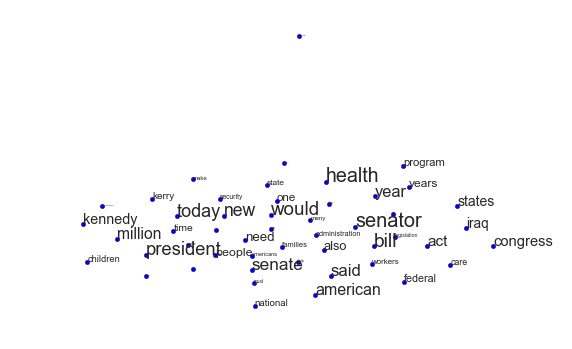

In [18]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1])
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

My visualization above puts ``said`` next to ``congress`` and ``bill`` near ``act``. ``health`` is beside ``care`` and ``national`` abuts ``security``.

## <span style="color:red">*Your Turn*</span>

<span style="color:red">Construct cells immediately below this that build a word2vec model with your corpus. Interrogate word relationships in the resulting space. Plot a subset of your words. What do these word relationships reveal about the *social* and *cultural game* underlying your corpus? What was surprising--what violated your prior understanding of the corpus? What was expected--what confirmed your knowledge about this domain?

# Doc2Vec

Instead of just looking at just how words embed within in the space, we can look at how the different documents relate to each other within the space. First lets load our data--abstracts of most U.S. physics papers from the 1950s.

In [19]:
apsDF = pandas.read_csv('data/APSabstracts1950s.csv', index_col = 0)
apsDF[:10]

,copyrightYear,doi,abstract
0,1950,10.1103/RevModPhys.22.221,A summarizing account is given of the research...
1,1951,10.1103/RevModPhys.23.147,New tables of coulomb functions are presented ...
2,1951,10.1103/RevModPhys.23.185,Ionization by electron impact in diatomic gase...
3,1951,10.1103/RevModPhys.23.203,It is shown that the conductivity in the ohmic...
4,1951,10.1103/RevModPhys.23.21,The factorization method is an operational pro...
5,1951,10.1103/RevModPhys.23.311,A brief account is given of Dyson's proof of t...
6,1951,10.1103/RevModPhys.23.315,A systematics is given of all transitions for ...
7,1951,10.1103/RevModPhys.23.322,A systematics of the -transitions of even A nu...
8,1951,10.1103/RevModPhys.23.328,The available experiments on the absorption sp...
9,1952,10.1103/RevModPhys.24.108,The classical theory of the dynamics of viscou...


We will load these as documents into Word2Vec, but first we need to normalize and pick some tags

In [20]:
keywords = ['photomagnetoelectric', 'quantum', 'boltzmann', 'proton', 'positron', 'feynman', 'classical', 'relativity']

In [21]:
apsDF['tokenized_words'] = apsDF['abstract'].apply(lambda x: nltk.word_tokenize(x))
apsDF['normalized_words'] = apsDF['tokenized_words'].apply(lambda x: normlizeTokens(x, stopwordLst = stop_words_nltk))

In [22]:
taggedDocs = []
for index, row in apsDF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['copyrightYear'])
    docKeywords.append(row['doi']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
apsDF['TaggedAbstracts'] = taggedDocs

Now we can train a Doc2Vec model:

In [23]:
apsD2V = gensim.models.doc2vec.Doc2Vec(apsDF['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions

We can get vectors for the tags/documents, just as we did with words. Documents are actually the centroids (high dimensional average points) of their words. 

In [24]:
apsD2V.docvecs[1952]

array([-0.16681562, -0.01980916,  0.03106602,  0.07283246,  0.01959223,
       -0.12992142,  0.04524063,  0.03839607,  0.10482809,  0.01969885,
        0.04658047,  0.0321001 , -0.04959451,  0.04864454,  0.06586186,
        0.02811554, -0.14940719,  0.02019905,  0.04197181, -0.00431161,
        0.06468363, -0.01654744,  0.10623043,  0.08349913,  0.10805746,
       -0.08268709,  0.12823337,  0.0598536 , -0.06868231, -0.04142373,
       -0.15392743,  0.09195267, -0.08791731,  0.03705133,  0.07262867,
       -0.0302698 ,  0.05971535,  0.03949324,  0.02972753, -0.21044861,
        0.09967899,  0.0428053 ,  0.02150623,  0.01905606,  0.17575012,
       -0.10752298,  0.09973518, -0.0940936 , -0.06689965, -0.06917495,
       -0.039964  , -0.06991497, -0.0859694 ,  0.10893779, -0.13621761,
        0.12941284,  0.03087168,  0.09305988, -0.05973294,  0.01785875,
        0.09512231, -0.03836443, -0.01131179,  0.01978041,  0.00139065,
        0.1118064 ,  0.09681217,  0.06193241,  0.03311415,  0.00

The words can still be accessed in the same way:

In [25]:
apsD2V['atom']

array([ 0.04490673, -0.09003967, -0.01072614, -0.04834561,  0.05899192,
       -0.01288092, -0.11330874, -0.05207485, -0.07327171,  0.0127025 ,
       -0.09146508,  0.14076319,  0.03465622,  0.02095531, -0.25210524,
        0.12633559, -0.17517853, -0.07499949, -0.07687739,  0.12232444,
       -0.0005159 , -0.08827048, -0.00873632,  0.02781452, -0.01724579,
        0.09034477, -0.01870035,  0.03576114,  0.09782551, -0.10089091,
       -0.00756095,  0.07649872, -0.04112473,  0.06829327, -0.07520822,
       -0.25908631,  0.00964217, -0.16874787,  0.08685401,  0.00805371,
        0.15398249,  0.03274738, -0.04255998,  0.07046147,  0.13462418,
        0.05319987, -0.04537142, -0.05499068,  0.1439124 ,  0.03304294,
        0.05889501,  0.06810348,  0.24968262,  0.06230617, -0.03183351,
        0.05080882, -0.15154248,  0.06318087,  0.06138504,  0.07297213,
        0.01364206,  0.11141364, -0.09286591, -0.00348273, -0.10209791,
        0.143594  , -0.02983916, -0.14118613, -0.19069391, -0.04

We can still use the ``most_similar`` command to perform simple semantic equations:

In [26]:
apsD2V.most_similar(positive = ['atom','electrons'], negative = ['electron'], topn = 1)

[('atoms', 0.7190207839012146)]

This is interesting. **Electron** is to **electrons** as **atom** is to **atoms**. Another way to understand this, developed below is: **electrons - electron** induces a singular to plural dimension, so when we subtract **electron** from **atom** and add **electrons**, we get **atoms**! 

In [27]:
apsD2V.most_similar(positive = ['einstein','law'], negative = ['equation'], topn = 1)

[('ehrenfest', 0.5340144634246826)]

In other words **Einstein** minus **equation** plus **law** equals **Meissner**--Walthur Meissner studied mechanical engineering and physics ... and was more likely to produce a "law" than a "equation", like the Meissner effect, the damping of the magnetic field in superconductors. If we built our word-embedding with a bigger corpus like the entire arXiv, a massive repository of physics preprints, we would see many more such relationships like **gravity - Newton + Einstein = relativity**.

We can also compute all of these *by hand*--explicitly wth vector algebra: 

In [28]:
sklearn.metrics.pairwise.cosine_similarity(apsD2V['electron'].reshape(1,-1), apsD2V['positron'].reshape(1,-1))
#We reorient the vectors with .reshape(1, -1) so that they can be computed without a warning in sklearn

array([[ 0.41000849]], dtype=float32)

In the doc2vec model, the documents have vectors just as the words do, so that we can compare documents with each other and also with words (similar to how a search engine locates a webpage with a query). First, we will calculate the distance between a word and documents in the dataset:

In [29]:
apsD2V.docvecs.most_similar([ apsD2V['electron'] ], topn=5 )

[('10.1103/PhysRev.102.1451', 0.4216521382331848),
 ('10.1103/PhysRev.91.582', 0.39200395345687866),
 ('10.1103/PhysRev.104.368', 0.3863754868507385),
 ('10.1103/PhysRev.100.1037', 0.3861256539821625),
 ('10.1103/PhysRev.106.874', 0.37214595079421997)]

If we search for the first of these on the web (these are doi codes), we find the following...a pretty good match:

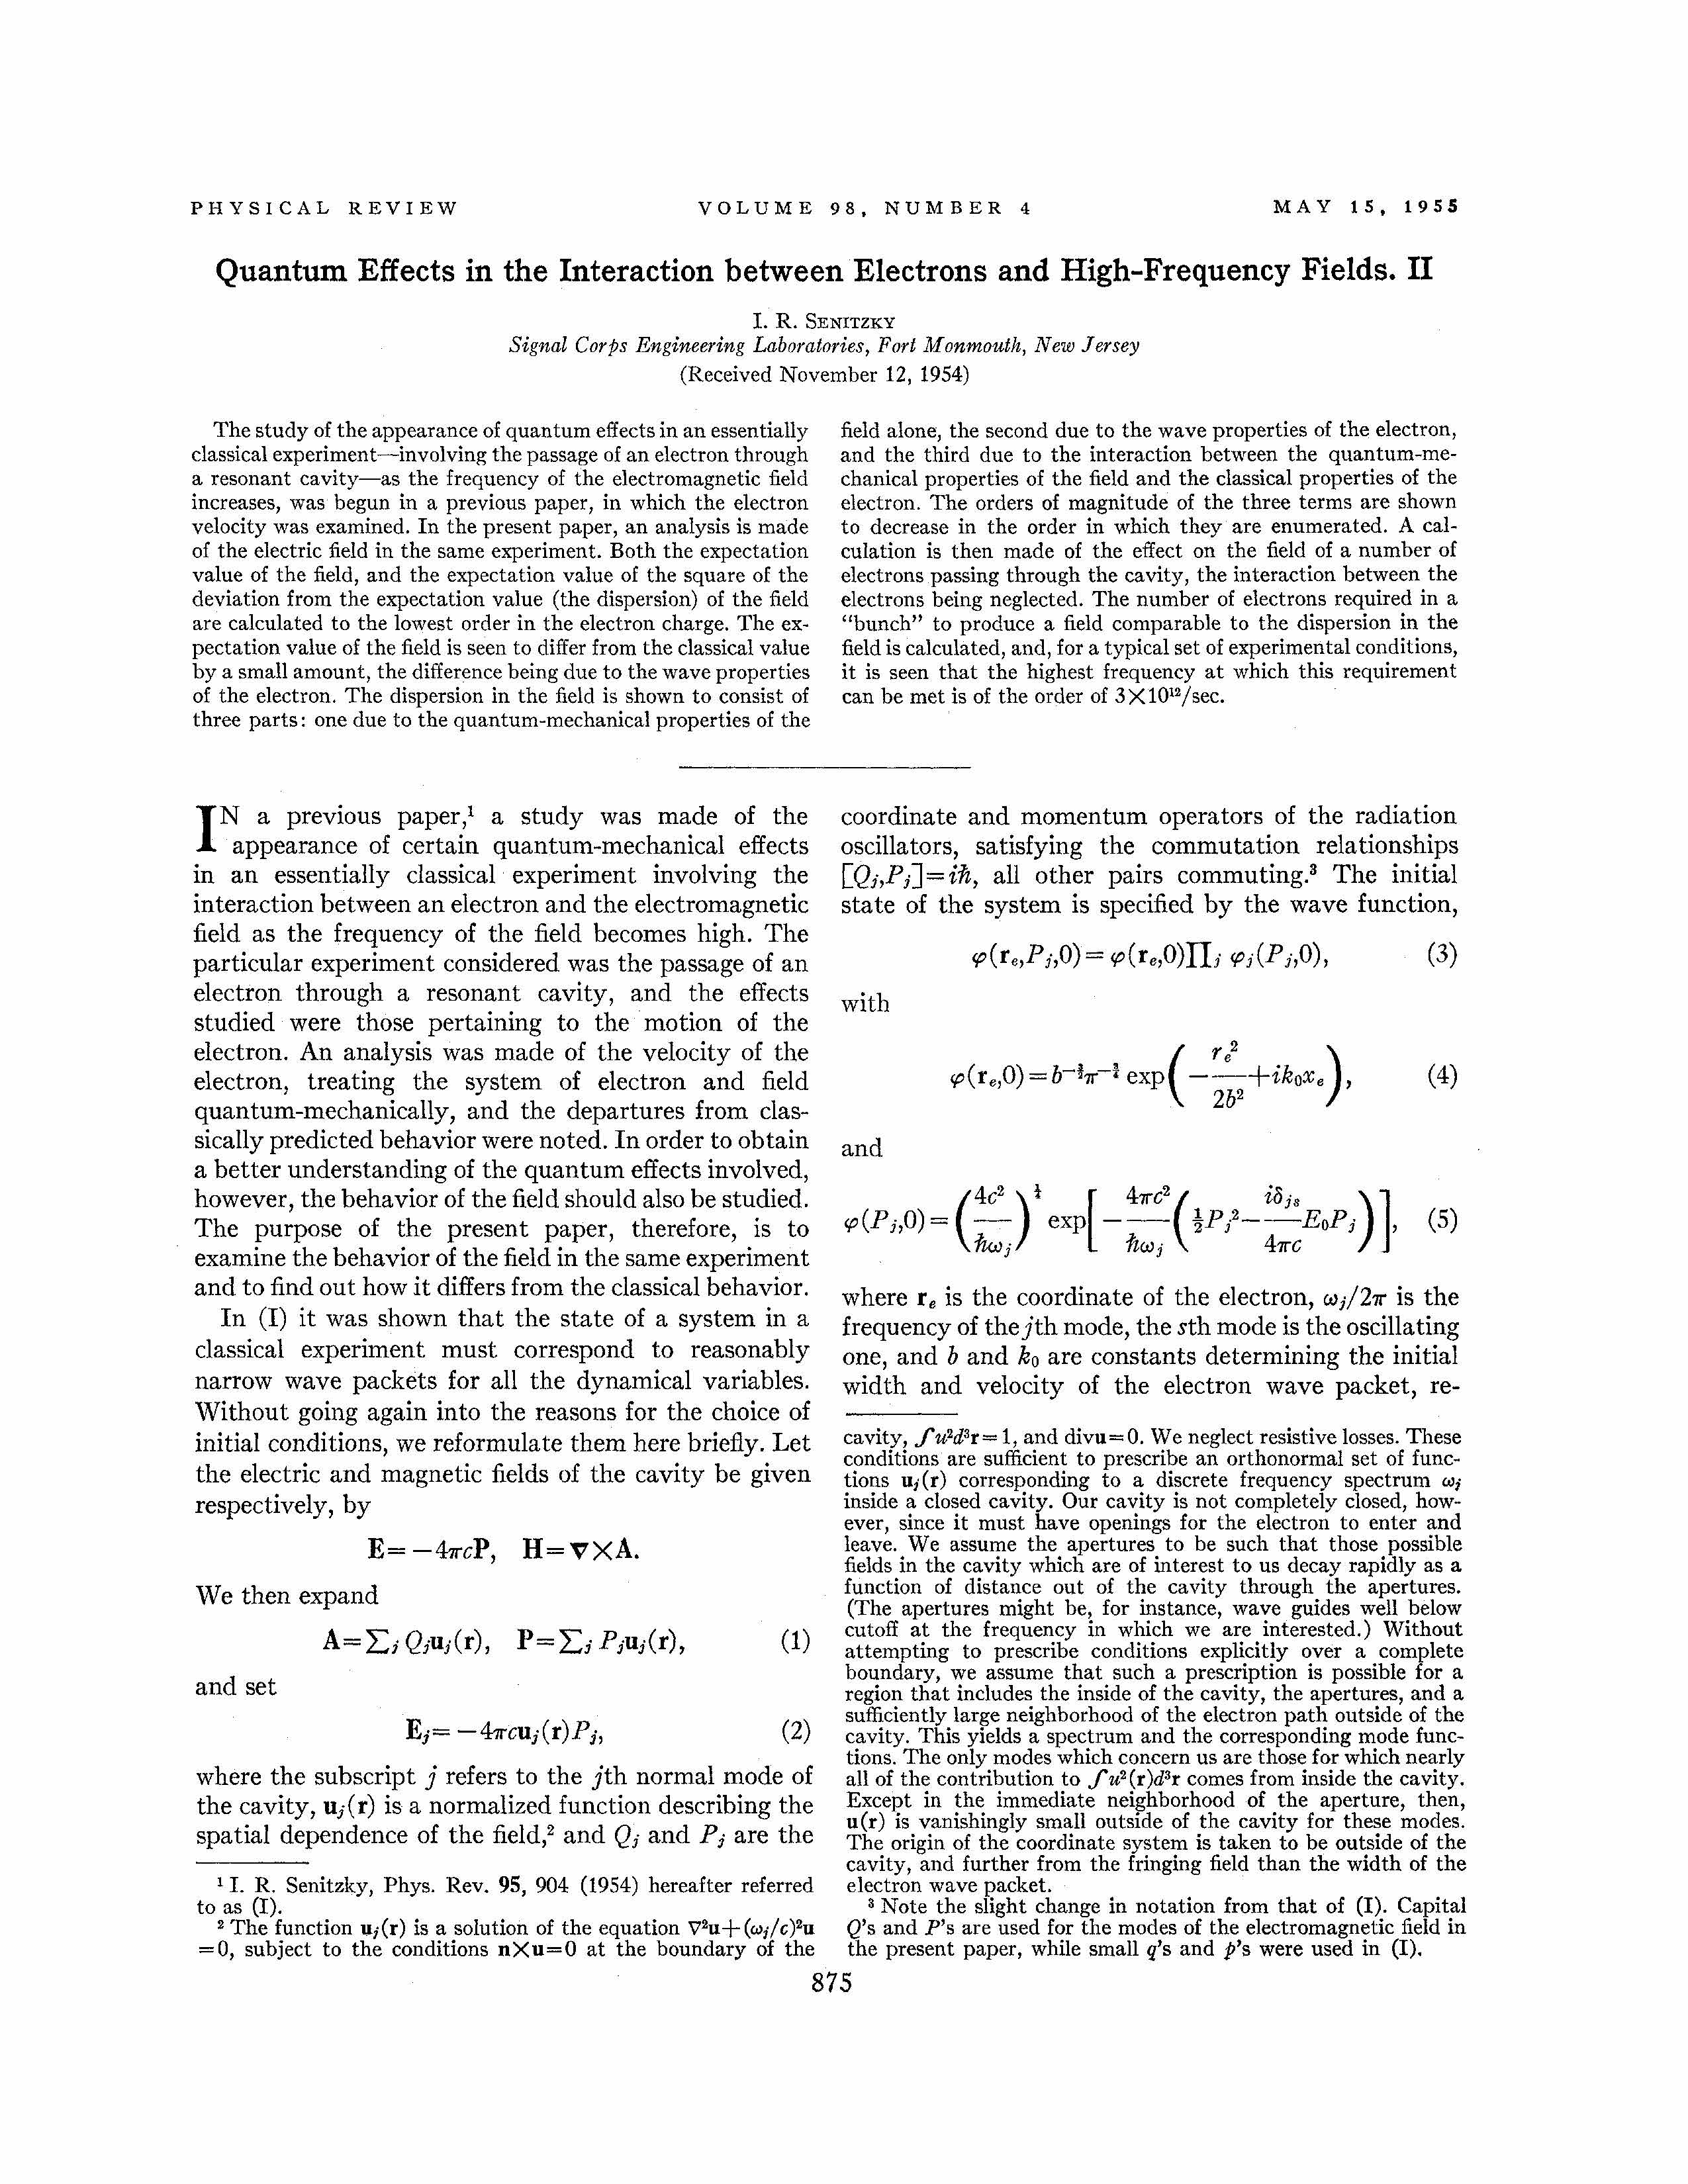

In [30]:
from IPython.display import Image
Image("PhysRev.98.875.jpg", width=1000, height=1000)

Now let's go the other way around and find words most similar to this document:

In [31]:
apsD2V.most_similar( [ apsD2V.docvecs['10.1103/PhysRev.98.875'] ], topn=5) 

[('microscope', 0.5011250972747803),
 ('contribute', 0.49250298738479614),
 ('trapped', 0.48323702812194824),
 ('holes', 0.46049895882606506),
 ('faster', 0.4600788950920105)]

We can even look for documents most like a query composed of multiple words:

In [32]:
apsD2V.docvecs.most_similar([ apsD2V['electron']+apsD2V['positron']+apsD2V['neutron']], topn=5 )

[('10.1103/PhysRev.86.976', 0.44008970260620117),
 ('10.1103/PhysRev.114.305', 0.4292910695075989),
 ('10.1103/PhysRev.110.448', 0.42206376791000366),
 ('10.1103/PhysRev.92.1527', 0.42182856798171997),
 ('10.1103/PhysRev.85.1012', 0.42129814624786377)]

Now let's plot some words and documents against one another with a heatmap:

In [33]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

In [34]:
heatmapMatrix.shape

(8, 8)

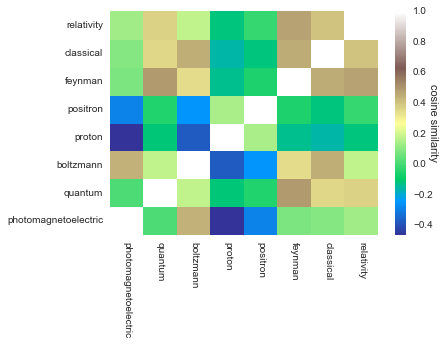

In [35]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

Now let's look at a heatmap of similarities between the first ten documents in the corpus:

In [36]:
targetDocs = apsDF['doi'][:10]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

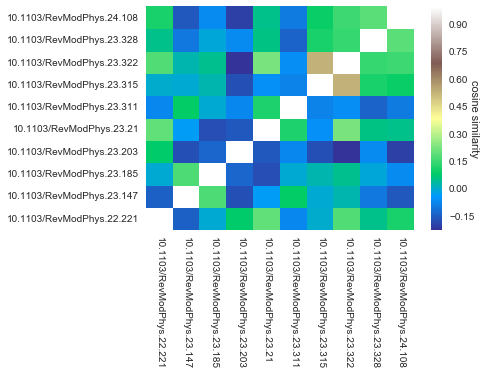

In [37]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

Now let's look at a heatmap of similarities between the first ten documents and our keywords:

In [38]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixD)

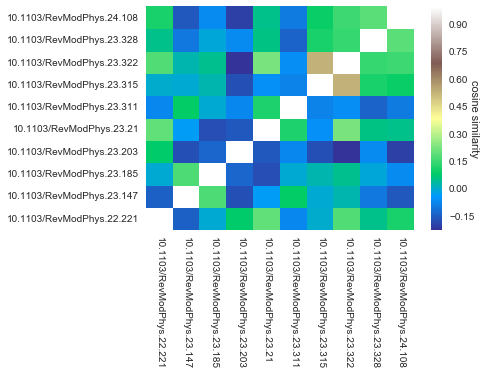

In [39]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

We will save the model in case we would like to use it again.

In [40]:
apsD2V.save('data/apsW2V')

We can later load it:

In [41]:
#apsD2V = gensim.models.word2vec.Word2Vec.load('data/apsW2V')

## <span style="color:red">*Your Turn*</span>

<span style="color:red">Construct cells immediately below this that build a doc2vec model with your corpus. Interrogate document and word relationships in the resulting space. Construct a heatmap that plots the distances between a subset of your documents against each other, and against a set of informative words. Find distances between *every* document in your corpus and a word or query of interest. What do these doc-doc proximities reveal about your corpus? What do these word-doc proximities highlight? Demonstrate and document one reasonable way to select a defensible subset of query-relevant documents for subsequent analysis.

# The Score Function

The score function is a simple calculation developed by [Matt Taddy](https://arxiv.org/pdf/1504.07295.pdf) to calculate the likelihood that a given text would have been generated by a word-embedding model by summing the inner product between each pair of the text's word vectors. 

Here, we explore this using a model trained with millions of resumes from the CareerBuilder website (we can't share the private resumes...but we can share a model built with them :-):

In [42]:
resume_model  = gensim.models.word2vec.Word2Vec.load('data/resumeAll.short.model')

We can examine the vacabularies of this model by building a word-index map:

In [43]:
vocab = resume_model.index2word

Let's load a few job ads. Here, we only use a small sample of all of them. Uncomment this cell if you want to load more.

In [44]:
with open('data/joblistings.merged.parsed.unique.grpbyyear.2010-2015.02.tsv','r') as tsv:
    ads = [line.strip().split('\t') for line in tsv]
    
adsDF = pandas.DataFrame(ads, columns = ads[0])
reducedDF = adsDF[['hiringOrganization_organizationName', 'jobDescription', 'jobLocation_address_region', 'jobLocation_geo_latitude', 'jobLocation_geo_longitude', 'qualifications', 'responsibilities']][1:]
N = reducedDF.shape[0]
indices = random.sample(range(1, N+1), 100)
sampleDF = reducedDF.iloc[indices]
sampleDF['tokenized_sents'] = sampleDF['jobDescription'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
sampleDF['normalized_sents'] = sampleDF['tokenized_sents'].apply(lambda x: [normlizeTokens(s, vocab = vocab) for s in x])
sampleDF.to_csv('data/SampleJobAds.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'data/joblistings.merged.parsed.unique.grpbyyear.2010-2015.02.tsv'

Let's just load the sample and take a look at it. The sentences in each job description are already tokenized and normalized.

In [ ]:
sampleDF = pandas.DataFrame.from_csv('data/SampleJobAds.csv', index_col = False)
#We need to convert the last couple columns from strings to lists
sampleDF['tokenized_sents'] = sampleDF['tokenized_sents'].apply(lambda x: eval(x))
sampleDF['normalized_sents'] = sampleDF['normalized_sents'].apply(lambda x: eval(x))
sampleDF

Let's define a function to calculate the likelihood of each job description. The idea is borrowed from [Matt Taddy](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/deepir.ipynb), who shows how a document can be characterized as the inner product of the distance between its words. In other words, this analysis will show which job ads are most likely to find an appropriate pool of workers in the resume bank that generated our word embedding.  

In [ ]:
def adprob(ad, model):
    sen_scores = model.score(ad, len(ad))
    ad_score = sen_scores.mean()
    return ad_score

Let's apply this function to every job description.

In [ ]:
sampleDF['likelihood'] = sampleDF['normalized_sents'].apply(lambda x: adprob(x, resume_model))

Let's take a look at the top 5 job descriptions that have the highest likelihood.

In [ ]:
for ad in sampleDF.sort_values(by = 'likelihood', ascending = False)['jobDescription'][:5]:
    print (ad + '\n\n')

Let's take a look at the bottom 5 job descriptions that have the lowest likelihood to be matched by the resumes.

In [ ]:
for ad in sampleDF.sort_values(by = 'likelihood')['jobDescription'][:5]:
    print (ad + '\n\n')

We can do the same for phrases corresponding to job skills.

In [ ]:
adprob("python programming", resume_model)

In [ ]:
adprob("basic programming", resume_model)

Basic programming appears to be less likely in this pool of resumes than python programming. 

We can also do some simple statistics. Unfortunately, we don't have a large sample here. Nevertheless, let's first look at the mean likelihood score of each hiring organization. Some organizations will do well to hire on CareerBuilder...while others will not.

In [ ]:
sampleDF.groupby("hiringOrganization_organizationName")[['likelihood']].mean().sort_values('likelihood', ascending = False)

We can also look at the mean likelihood of each state.

In [ ]:
sampleDF.groupby("jobLocation_address_region")[['likelihood']].mean().sort_values('likelihood', ascending = False)

You would increase the sample size if you want to do a more serious study.

## <span style="color:red">*Your Turn*</span>

<span style="color:red">Construct cells immediately below this that calculate the scores for a small sample of documents from outside your corpus to identify which are *closest* to your corpus. Then calculate the scores for a few phrases or sentences to identify the ones most likely to have appeared in your corpus. Interrogate patterns associated with these document/phrase scores (e.g., which companies produced job ads most or least likely to find jobseekers in the resume corpus?) What do these patterns suggest about the boundaries of your corpus?

# Projection

We can also project word vectors to an arbitray semantic dimension. To demonstrate this possibility, let's first load a model trained with New York Times news articles. 

In [45]:
nytimes_model = gensim.models.word2vec.Word2Vec.load_word2vec_format('data/nytimes_cbow.reduced.txt')

First we can visualize with dimension reduction

In [57]:
#words to create dimensions
tnytTargetWords = ['man','him','he', 'woman', 'her', 'she', 'black','blacks','African', 'white', 'whites', 'Caucasian', 'rich', 'richer', 'richest', 'expensive', 'wealthy', 'poor', 'poorer', 'poorest', 'cheap', 'inexpensive']
#words we will be mapping
tnytTargetWords += ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse", "steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry", "basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(nytimes_model[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-0.34313899, -0.117117  , -0.50773001, ..., -0.99569601,
         0.92129898,  0.94376898],
       [-0.36290899, -0.26352799,  0.032661  , ..., -0.043032  ,
        -0.178965  ,  0.35355601],
       [-0.70166999, -0.34452501, -0.320714  , ...,  0.009001  ,
         0.11055   ,  0.751077  ],
       ..., 
       [-2.39162588, -1.90143001,  1.03118205, ...,  2.94746399,
         1.01587999,  2.00032997],
       [-2.43238711, -1.16141498,  1.06006396, ...,  4.40238094,
         0.500471  ,  1.64459598],
       [ 0.98193097,  0.62809402, -0.74754697, ...,  1.61292696,
         1.14806294,  1.06377602]], dtype=float32)

In [58]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

In [70]:
tsneWordsNYT[:,1].shape

(54,)

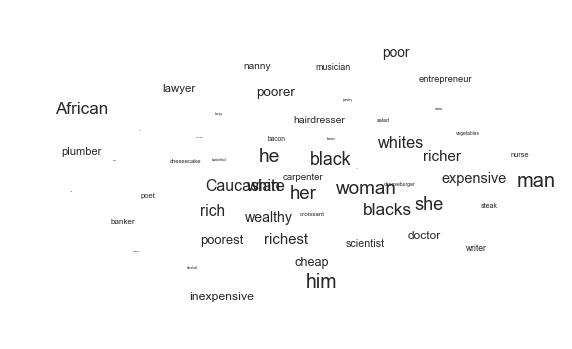

In [75]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible 
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  20 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

Define some convenient functions for getting dimensions. 

In [46]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

In [47]:
#nytimes_model['already']

Let's calculate three dimensions: gender, race, and class.

In [48]:
Gender = dimension(nytimes_model, ['man','him','he'], ['woman', 'her', 'she'])
Race = dimension(nytimes_model, ['black','blacks','African'], ['white', 'whites', 'Caucasian'])
Class = dimension(nytimes_model, ['rich', 'richer', 'richest', 'expensive', 'wealthy'], ['poor', 'poorer', 'poorest', 'cheap', 'inexpensive'])

Here we have some words.

In [49]:
Occupations = ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse"]

Foods = ["steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry"]

Sports  = ["basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]

Define a function to project words in a word list to each of the three dimensions.

In [50]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'gender': g, 'race': r, 'class': c}, index = word_list)
    return df

Get the projections.

In [51]:
OCCdf = makeDF(nytimes_model, Occupations) 
Fooddf = makeDF(nytimes_model, Foods)
Sportsdf = makeDF(nytimes_model, Sports)

Define some useful functions for plotting.

In [52]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

Plot the occupational words in each of the three dimensions.

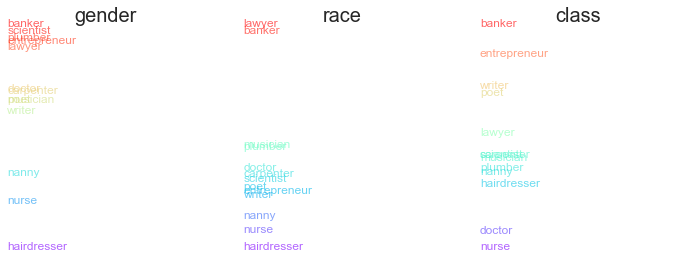

In [53]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OCCdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, OCCdf, 'class')
plt.show()

Foods:

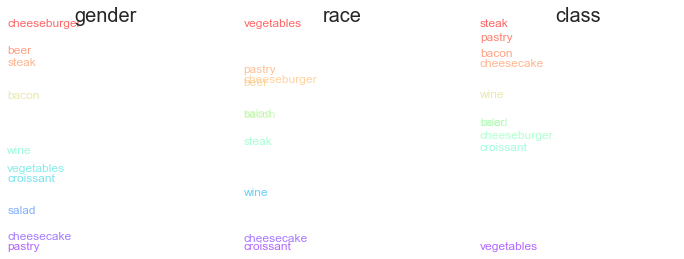

In [54]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Fooddf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Fooddf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Fooddf, 'class')
plt.show()

Sports:

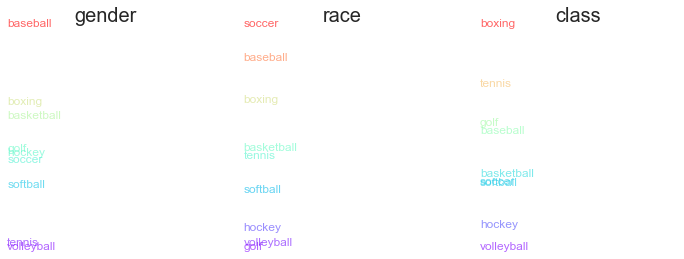

In [55]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Sportsdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Sportsdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Sportsdf, 'class')
plt.show()

## <span style="color:red">*Your Turn*</span>

<span style="color:red">Construct cells immediately below this that identify semantic dimensions of interest from your data (e.g., gender: man-woman) and project words onto these dimensions. Plot the array of relevant words along each semantic dimension. Which words are most different. Which dimensions are most different? On which dimension are your words most different? Print three short textual examples from the corpus that illustrate the association you have explored.

<span style="color:red">***Stretch***: Project documents from your corpus along a dimension of interest. Sample relevant documents from your corpus with this functionality and explain your rationale? Calculate the cosine of the angle between two dimensions (encoded as vectors) of interest. What does this suggest about the relationship between them within your corpus? 

<span style="color:red">***Super stretch***: Create 90% bootstrap confidence intervals around your word projections onto a given dimension by generating 10 separate word2vec models, sampling $n$ documents (the total number in your corpus) for each, but with replacement. The bounds will be defined as the highest and lowest projection across your 10 samples. Which words are *significantly* different on your semantic dimension of interest?